# **Breast Cancer Dataset**

### *Preparing the dataset*

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo

In [2]:
# Fetch dataset
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17)

# Data (as pandas dataframes)
X = breast_cancer_wisconsin_diagnostic.data.features
y = breast_cancer_wisconsin_diagnostic.data.targets

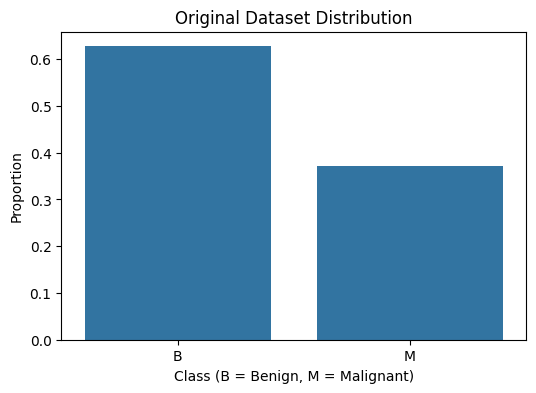

In [3]:
# Visualize original dataset distribution
original_dist = y.value_counts(normalize=True)

original_dist.index = original_dist.index.get_level_values(0)

plt.figure(figsize=(6, 4))
sns.barplot(x=original_dist.index, y=original_dist.values)
plt.title("Original Dataset Distribution")
plt.xlabel("Class (B = Benign, M = Malignant)")
plt.ylabel("Proportion")
plt.show()
plt.close()

In [4]:
def split_and_visualize(X, y, train_size) -> tuple:
    # Perform stratified splitting
    feature_train, feature_test, label_train, label_test = train_test_split(
        X, y, train_size=train_size, stratify=y, random_state=42
    )

    # Visualize class distribution
    train_dist = label_train.value_counts(normalize=True)
    test_dist = label_test.value_counts(normalize=True)

    print(f"Training set distribution (Train size = {train_size}):")
    print(train_dist)
    print(f"Test set distribution (Train size = {train_size}):")
    print(test_dist)

    train_dist.index = train_dist.index.get_level_values(0)
    test_dist.index = test_dist.index.get_level_values(0)

    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    sns.barplot(x=train_dist.index, y=train_dist.values, ax=ax[0])
    ax[0].set_title("Training Set Distribution")
    sns.barplot(x=test_dist.index, y=test_dist.values, ax=ax[1])
    ax[1].set_title("Test Set Distribution")
    plt.show()
    plt.close()

    return feature_train, feature_test, label_train, label_test


--- Train/Test Split: 40/60 ---
Training set distribution (Train size = 0.4):
Diagnosis
B            0.625551
M            0.374449
Name: proportion, dtype: float64
Test set distribution (Train size = 0.4):
Diagnosis
B            0.628655
M            0.371345
Name: proportion, dtype: float64


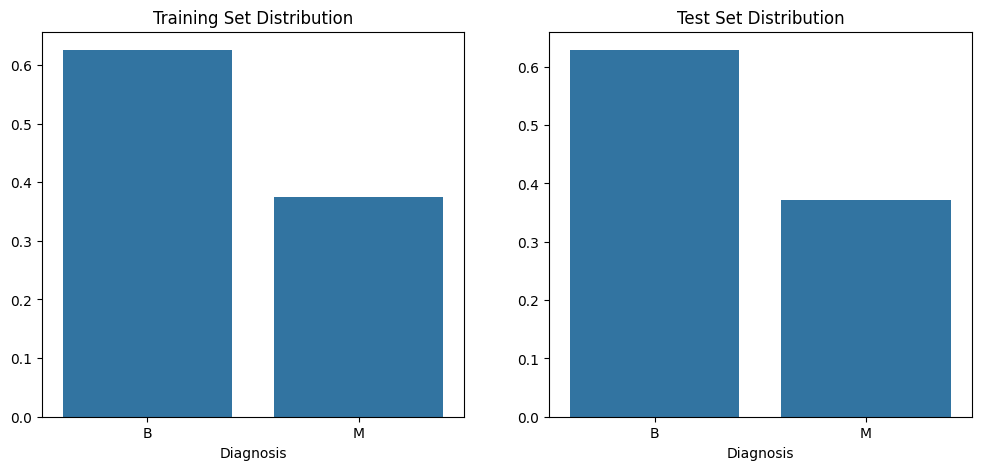


--- Train/Test Split: 60/40 ---
Training set distribution (Train size = 0.6):
Diagnosis
B            0.627566
M            0.372434
Name: proportion, dtype: float64
Test set distribution (Train size = 0.6):
Diagnosis
B            0.627193
M            0.372807
Name: proportion, dtype: float64


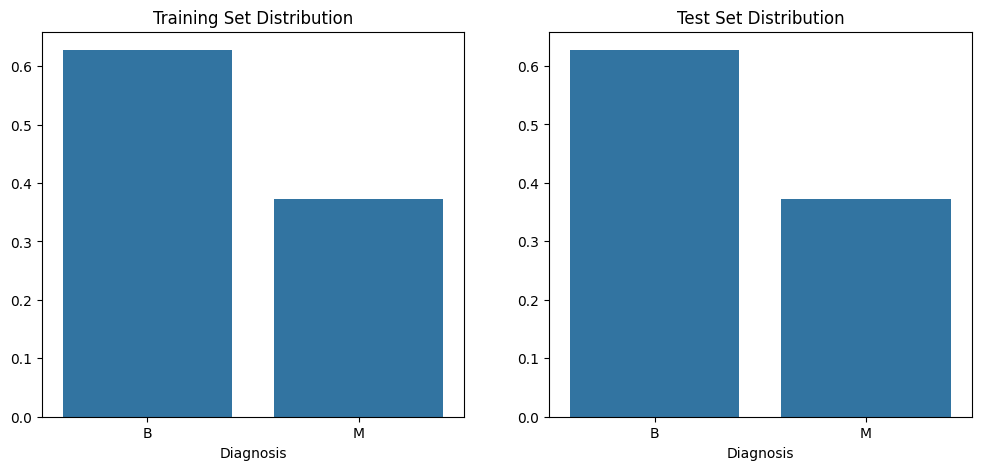


--- Train/Test Split: 80/20 ---
Training set distribution (Train size = 0.8):
Diagnosis
B            0.626374
M            0.373626
Name: proportion, dtype: float64
Test set distribution (Train size = 0.8):
Diagnosis
B            0.631579
M            0.368421
Name: proportion, dtype: float64


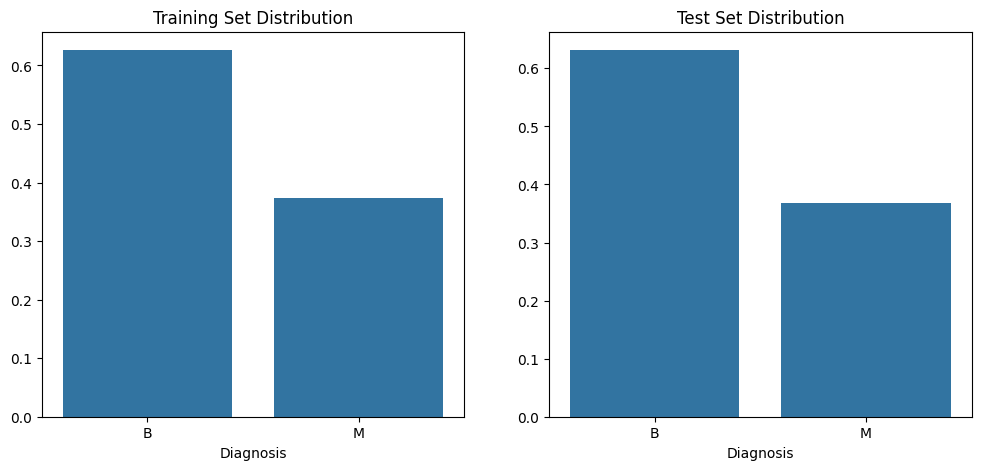


--- Train/Test Split: 90/10 ---
Training set distribution (Train size = 0.9):
Diagnosis
B            0.626953
M            0.373047
Name: proportion, dtype: float64
Test set distribution (Train size = 0.9):
Diagnosis
B            0.631579
M            0.368421
Name: proportion, dtype: float64


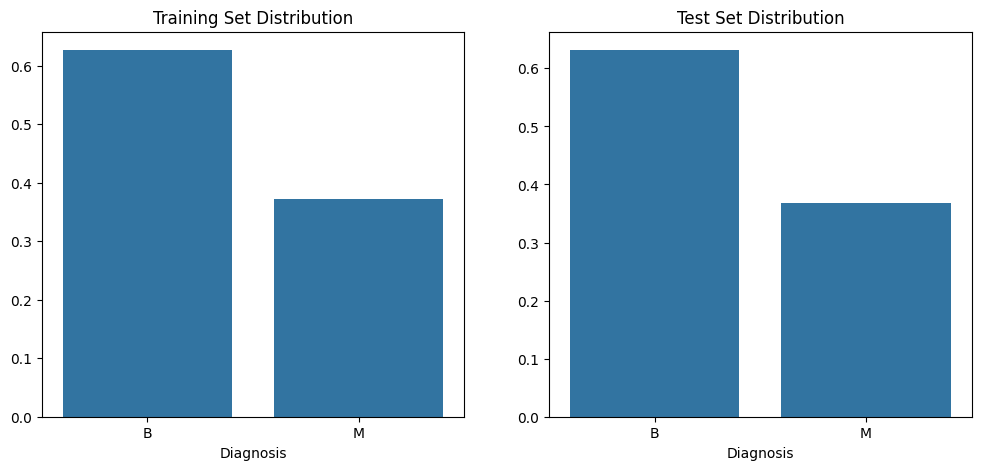

In [5]:
splits = [0.4, 0.6, 0.8, 0.9]

# Store the subsets
datasets = []

for split in splits:
    print(f"\n--- Train/Test Split: {int(round(split*100))}/{int(round((1-split)*100))} ---")
    feature_train, feature_test, label_train, label_test = split_and_visualize(X, y, split)
    datasets.append({
        "train_size": split,
        "feature_train": feature_train,
        "label_train": label_train,
        "feature_test": feature_test,
        "label_test": label_test
    })

### *Building the decision tree classifier*

In [6]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from graphviz import Source
from IPython.display import Image, display
import os
import sys
sys.stderr = open(os.devnull, 'w')  # Redirecting stderr to null

In [7]:
# Define the folder where images will be saved
output_folder = "BC_dataset_decision_trees"
os.makedirs(output_folder, exist_ok=True)  # Create the folder if it doesn't exist

In [8]:
def train_and_visualize_decision_tree(feature_train, label_train, train_size, output_folder) -> tuple:
    # Ensure the label is a pandas Series
    if isinstance(label_train, pd.DataFrame):
        label_train = label_train.squeeze()

    # Initialize the classifier
    clf = DecisionTreeClassifier(criterion='entropy', random_state=42)
    clf.fit(feature_train, label_train)

    # Get the depth of the trained tree
    tree_depth = clf.get_depth()

    # Sort the class names to match their internal order in the tree
    sorted_class_names = sorted(label_train.unique())

    # Export the decision tree as DOT data
    dot_data = export_graphviz(
        clf,
        out_file=None,
        feature_names=feature_train.columns,
        class_names=sorted_class_names,
        filled=True,
        rounded=True,
        special_characters=True
    )
    
    # Ensure the output folder exists
    os.makedirs(output_folder, exist_ok=True)

    # Render and save the tree visualization
    image_path = os.path.join(output_folder, f"DecisionTree_{int(train_size * 100)}")
    graph = Source(dot_data)
    graph.render(image_path, format='png', cleanup=True)

    # Display the decision tree image in the notebook
    display(Image(filename=image_path + ".png", width=1300))

    return clf, tree_depth



--- Training Decision Tree (Train size = 0.4) ---


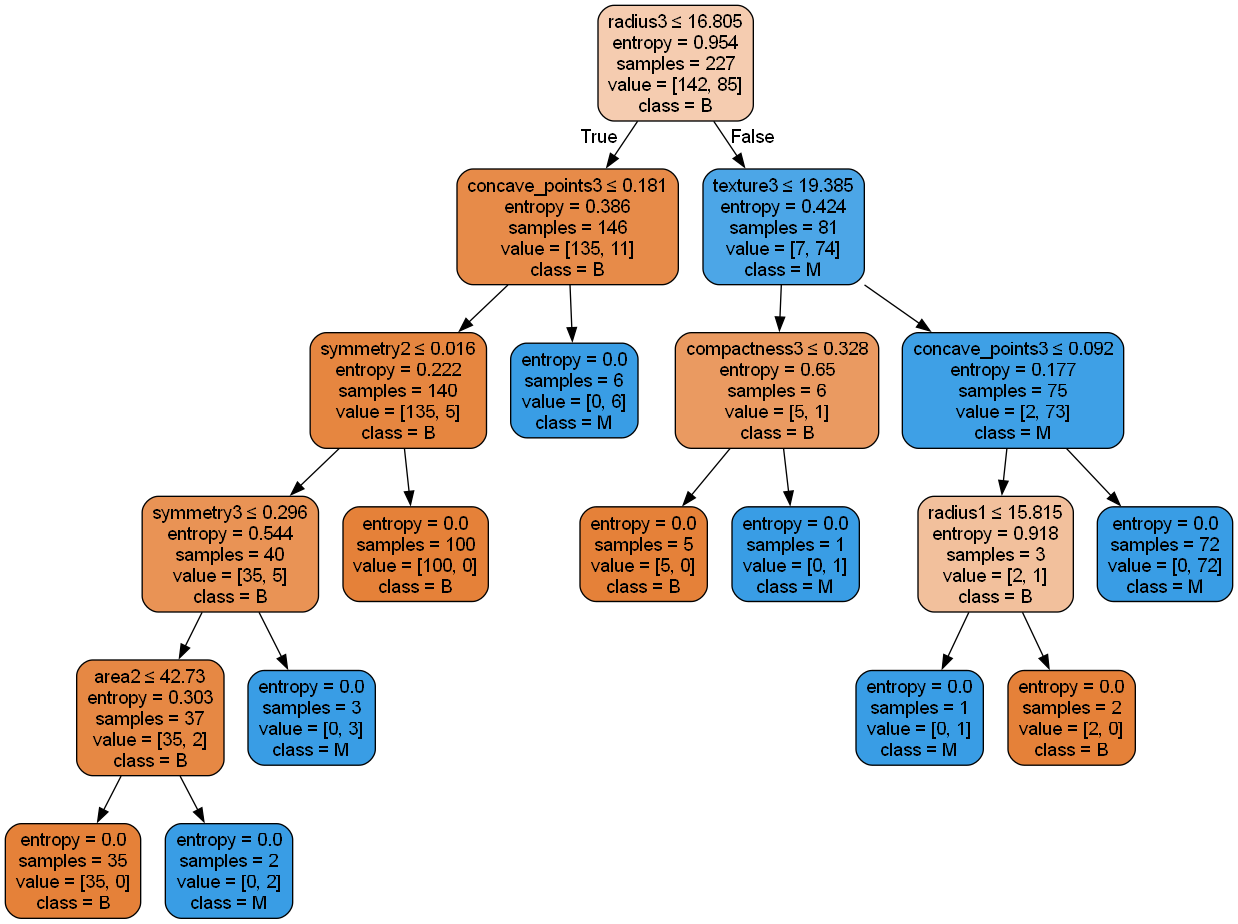

Decision Tree Depth: 5

--- Training Decision Tree (Train size = 0.6) ---


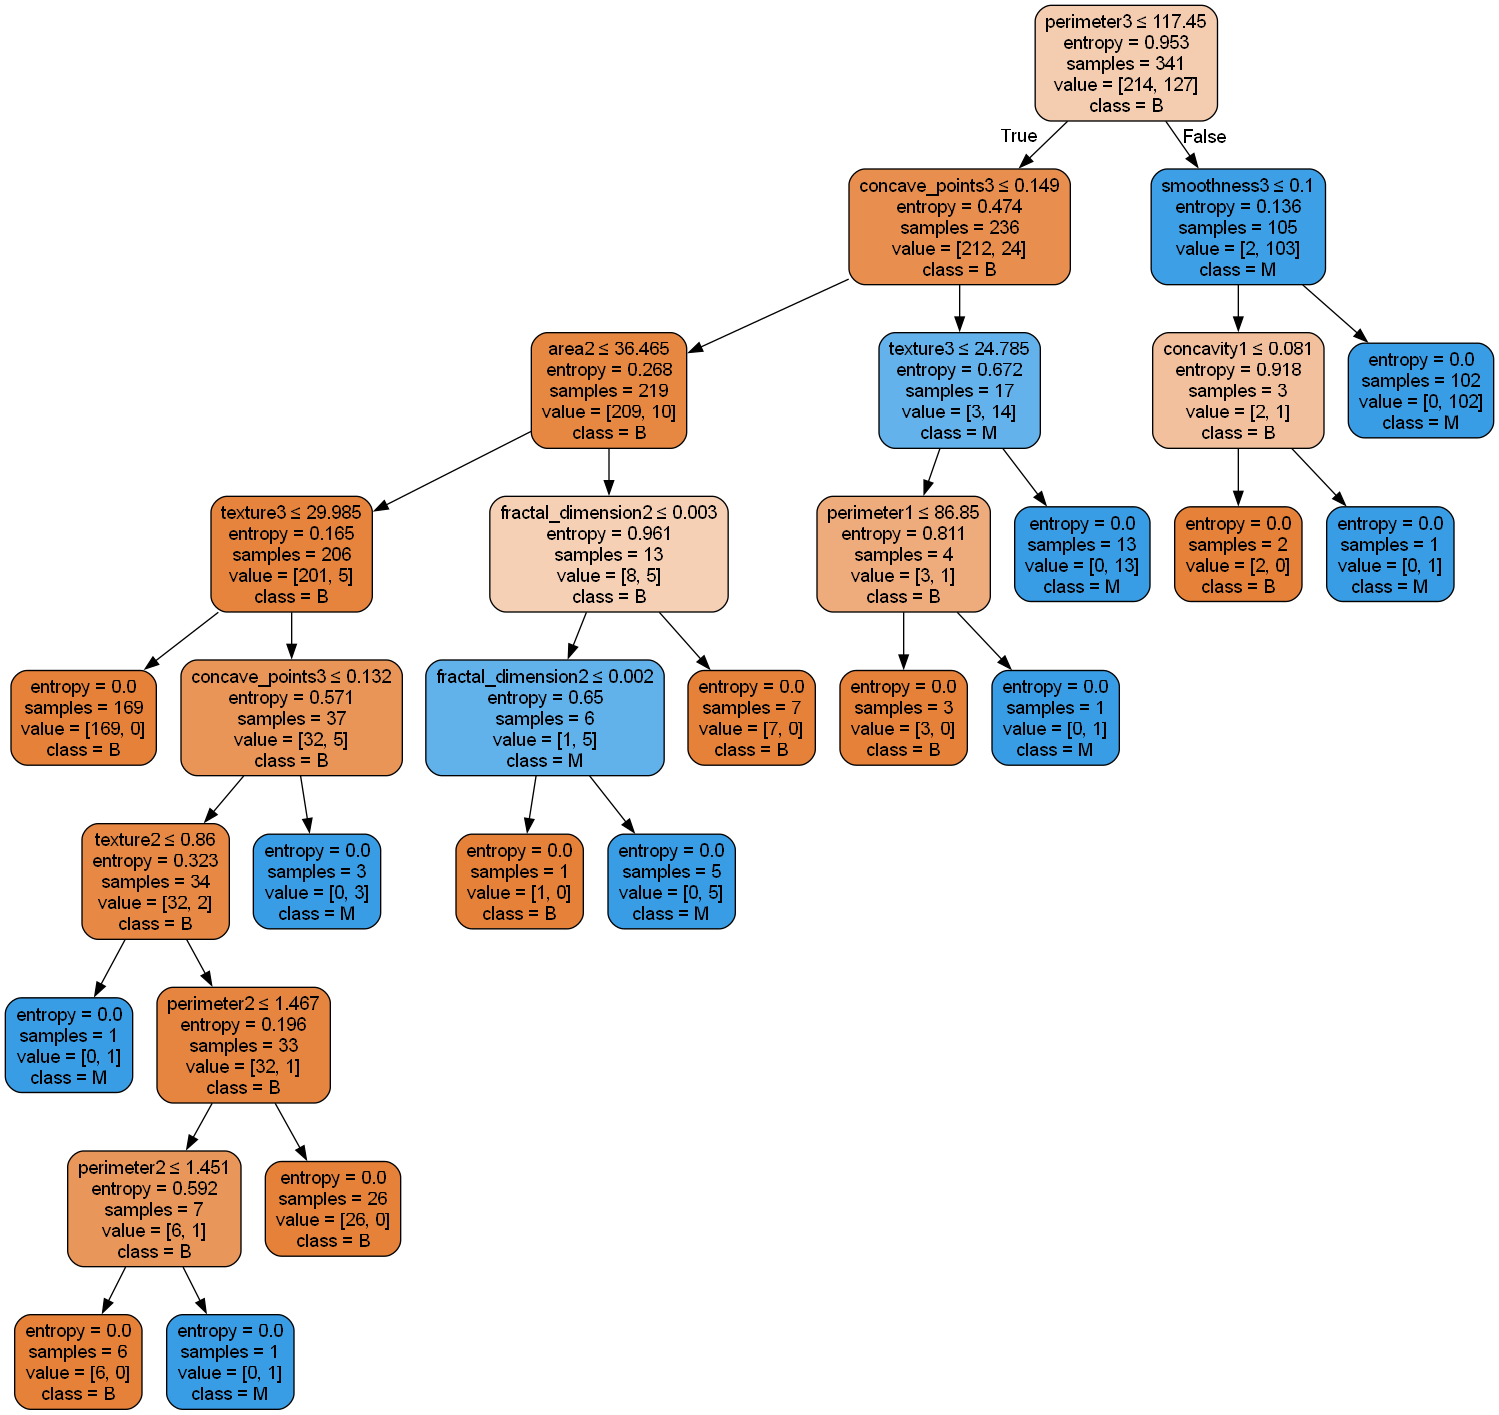

Decision Tree Depth: 8

--- Training Decision Tree (Train size = 0.8) ---


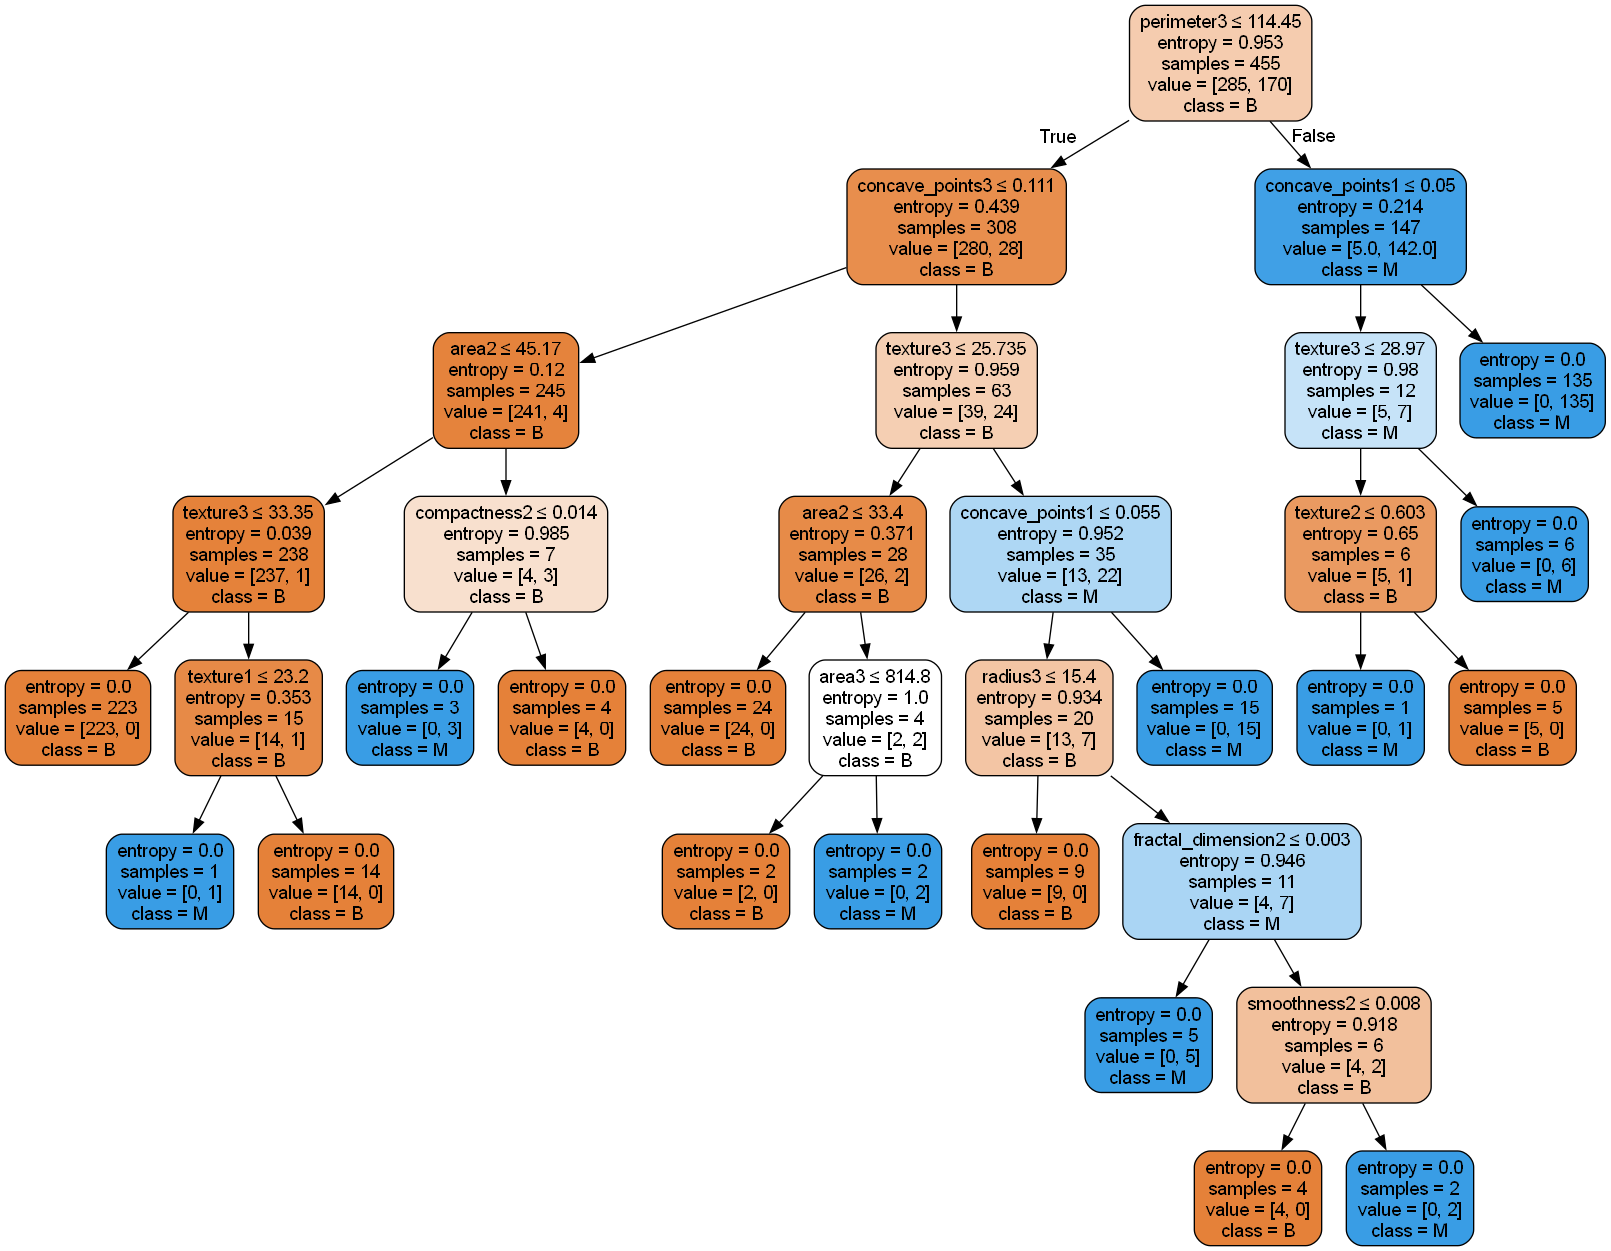

Decision Tree Depth: 7

--- Training Decision Tree (Train size = 0.9) ---


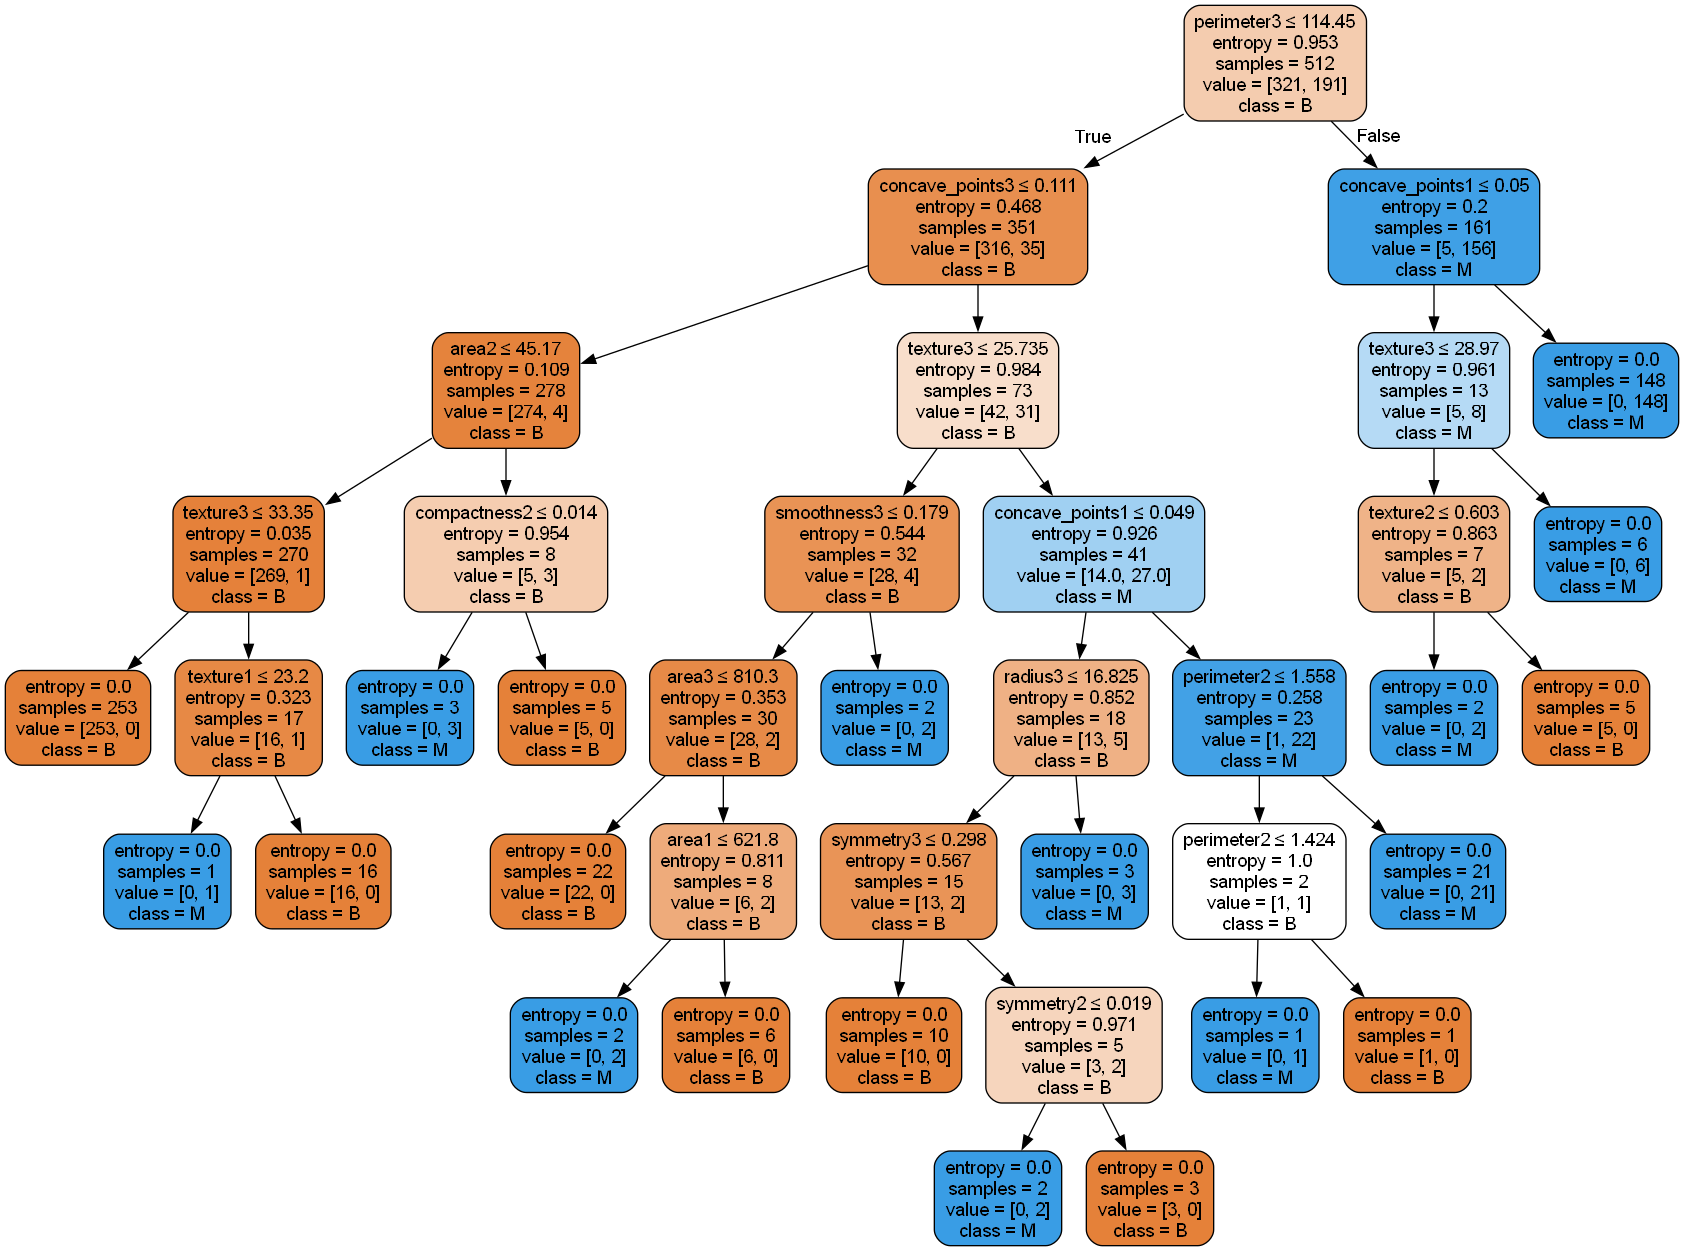

Decision Tree Depth: 7


In [9]:
# Initialize an empty dictionary to store trained classifiers
trained_classifiers = {}

# Train and visualize decision trees for each split
for dataset in datasets:
    print(f"\n--- Training Decision Tree (Train size = {dataset['train_size']}) ---")
    
    # Train and get depth
    clf, tree_depth = train_and_visualize_decision_tree(
        dataset['feature_train'],
        dataset['label_train'],
        dataset['train_size'],
        output_folder
    )

    # Print the depth after training
    print(f"Decision Tree Depth: {tree_depth}")
    
    # Store the trained classifier
    train_size_str = str(dataset['train_size'])  # Use train size as key
    trained_classifiers[train_size_str] = clf

### *Evaluating the decision tree classifier*

In [10]:
from sklearn.metrics import classification_report, confusion_matrix

In [11]:
def evaluate_decision_tree(clf, feature_test, label_test, train_size):
    # Define custom labels for the axes
    category_labels = ["B", "M"]
    
    # Make predictions on the test set
    predictions = clf.predict(feature_test)
    
    # Generate the classification report
    report = classification_report(label_test, predictions, target_names=category_labels)
    print(f"Classification Report for Train Size = {train_size}:\n")
    print(report)
    
    # Generate the confusion matrix
    cm = confusion_matrix(label_test, predictions, labels=category_labels)
    
    # Visualize the confusion matrix using seaborn heatmap
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=category_labels, yticklabels=category_labels)
    plt.title(f"Confusion Matrix (Train Size = {train_size})")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()
    plt.close()


--- Evaluating Decision Tree (Train size = 0.4) ---
Classification Report for Train Size = 0.4:

              precision    recall  f1-score   support

           B       0.91      0.96      0.93       215
           M       0.92      0.83      0.88       127

    accuracy                           0.91       342
   macro avg       0.91      0.90      0.90       342
weighted avg       0.91      0.91      0.91       342



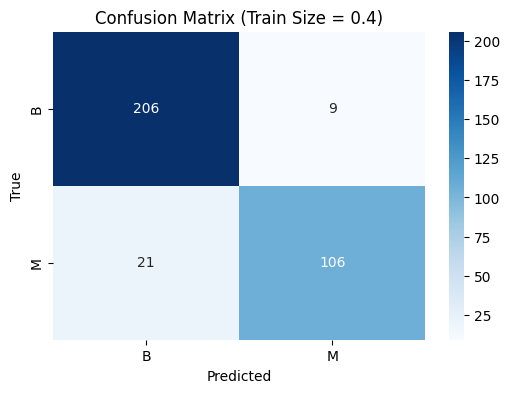


--- Evaluating Decision Tree (Train size = 0.6) ---
Classification Report for Train Size = 0.6:

              precision    recall  f1-score   support

           B       0.94      0.96      0.95       143
           M       0.93      0.91      0.92        85

    accuracy                           0.94       228
   macro avg       0.94      0.93      0.93       228
weighted avg       0.94      0.94      0.94       228



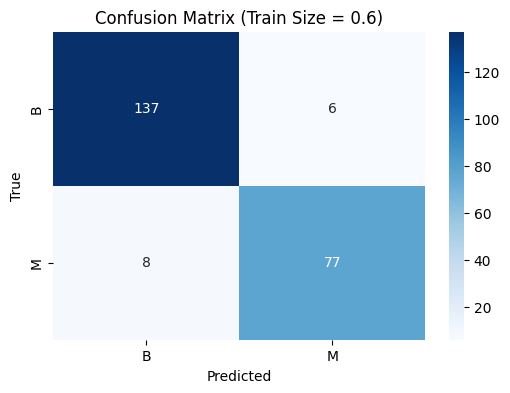


--- Evaluating Decision Tree (Train size = 0.8) ---
Classification Report for Train Size = 0.8:

              precision    recall  f1-score   support

           B       0.95      0.99      0.97        72
           M       0.97      0.90      0.94        42

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



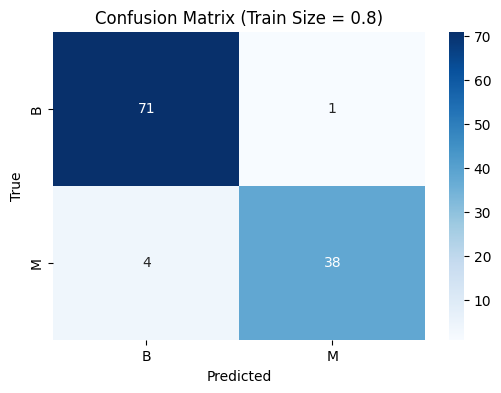


--- Evaluating Decision Tree (Train size = 0.9) ---
Classification Report for Train Size = 0.9:

              precision    recall  f1-score   support

           B       0.95      0.97      0.96        36
           M       0.95      0.90      0.93        21

    accuracy                           0.95        57
   macro avg       0.95      0.94      0.94        57
weighted avg       0.95      0.95      0.95        57



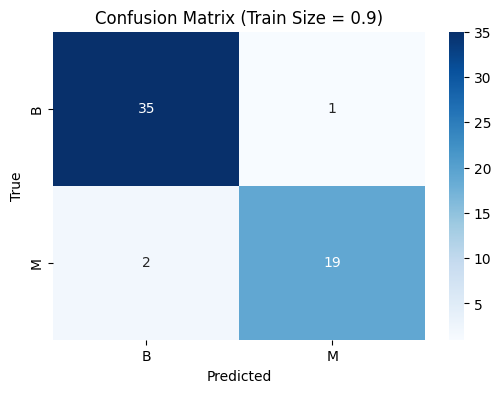

In [12]:
for dataset in datasets:
    train_size_str = str(dataset['train_size'])  # Retrieve the key for the classifier
    clf = trained_classifiers[train_size_str]  # Retrieve the trained classifier
    
    # Evaluate the trained classifier on the test set
    print(f"\n--- Evaluating Decision Tree (Train size = {dataset['train_size']}) ---")
    evaluate_decision_tree(clf, dataset['feature_test'], dataset['label_test'], dataset['train_size'])

In [13]:
from sklearn.metrics import accuracy_score

In [14]:
# Folder to save decision tree images
output_folder = "BC_dataset_decision_trees\max_depth_trees"
os.makedirs(output_folder, exist_ok=True)

In [15]:
# Values for max_depth
depth_values = [None, 2, 3, 4, 5, 6, 7]
accuracy_results = []

Decision Tree (max_depth=None):


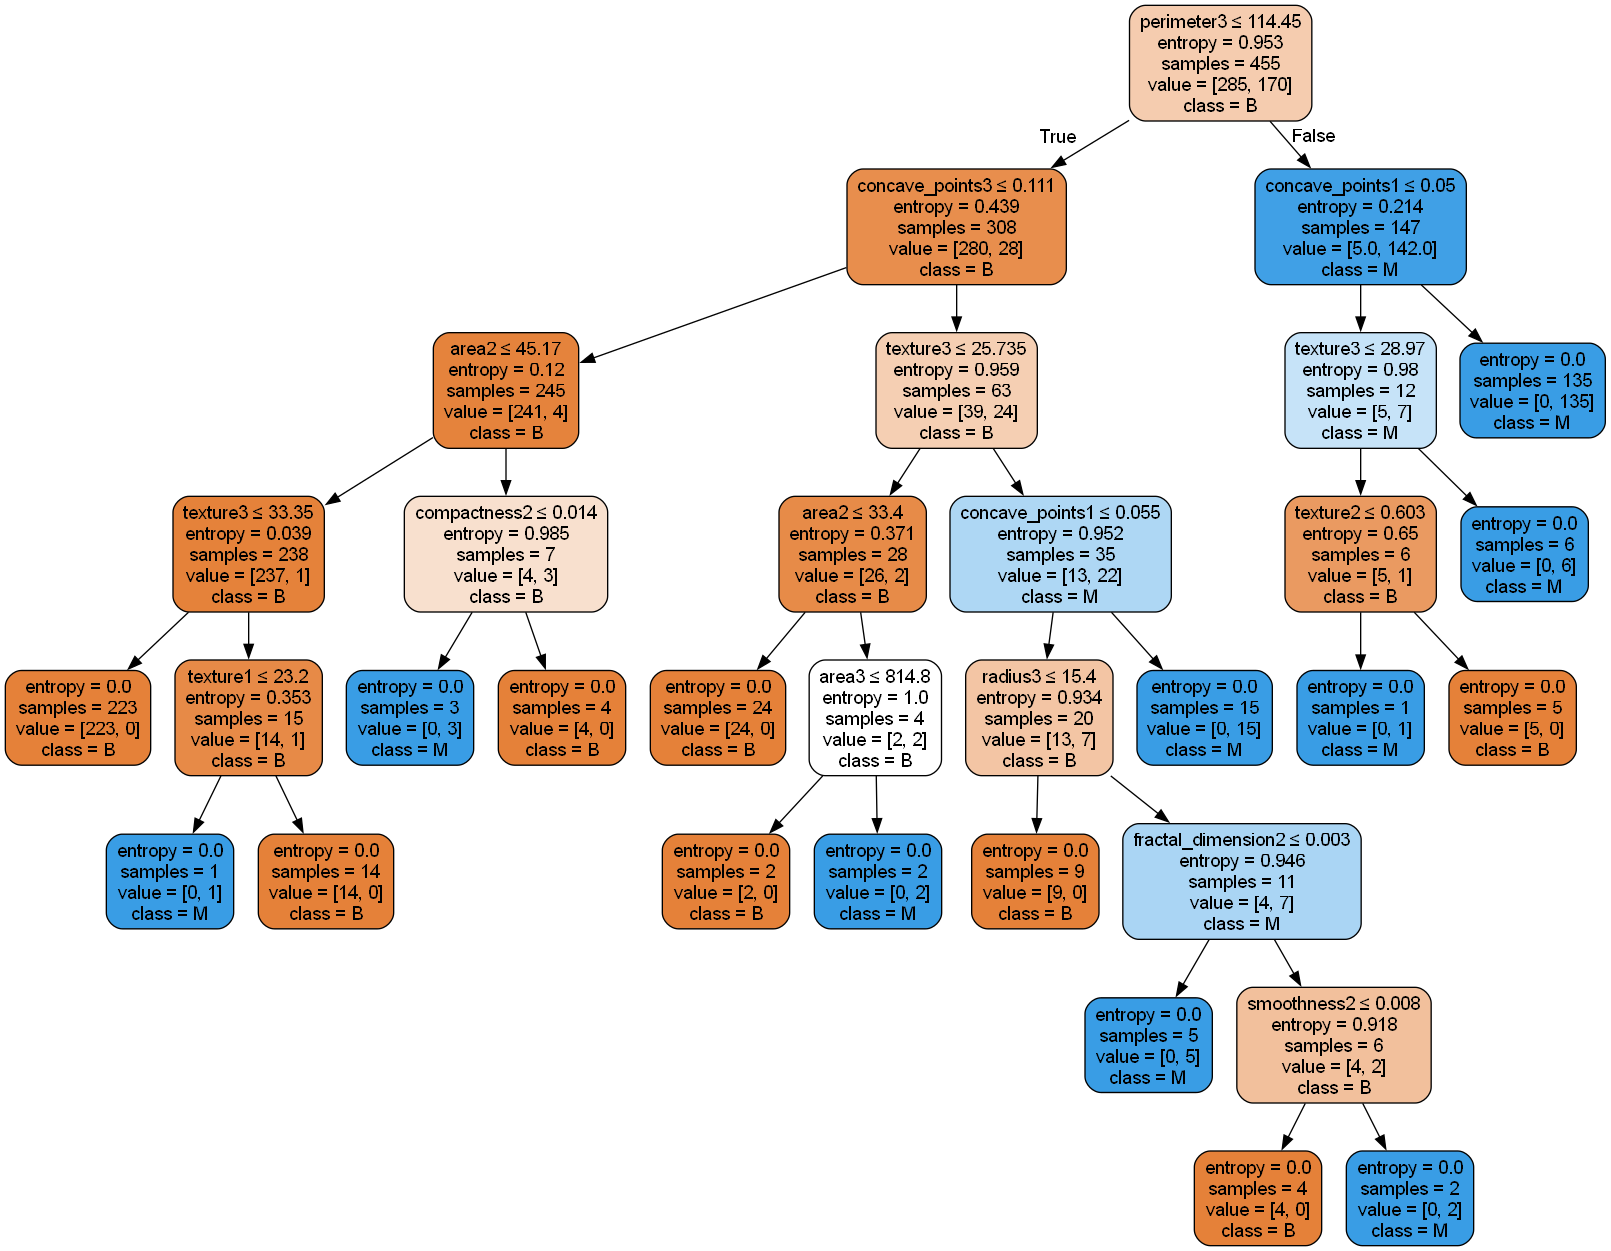

Decision Tree (max_depth=2):


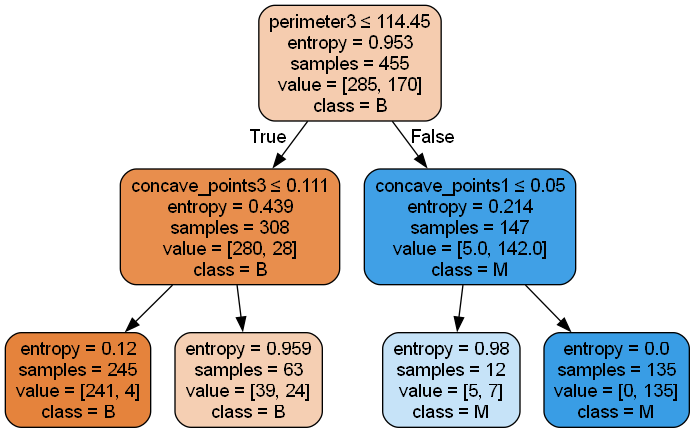

Decision Tree (max_depth=3):


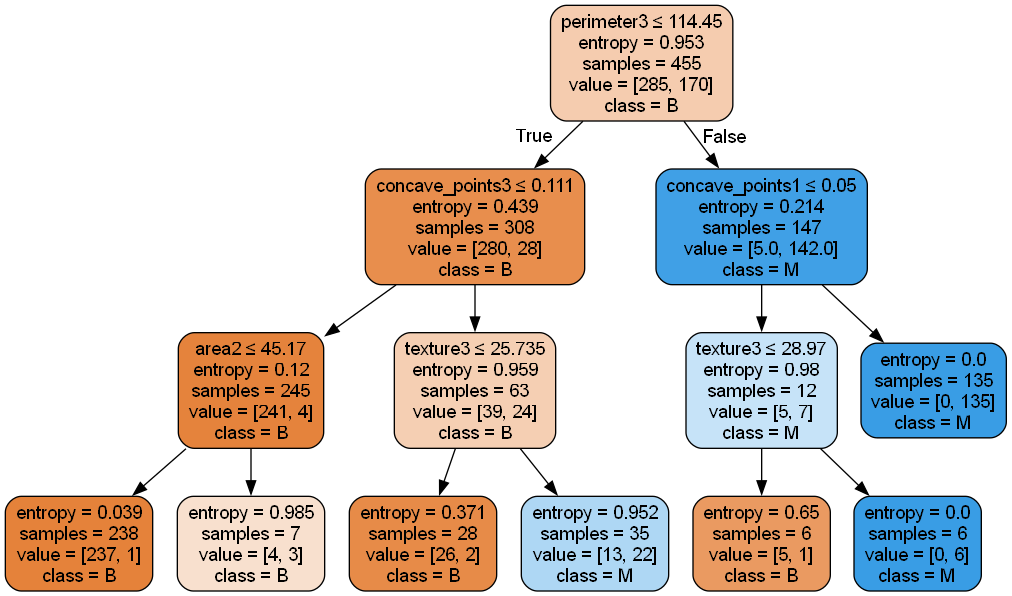

Decision Tree (max_depth=4):


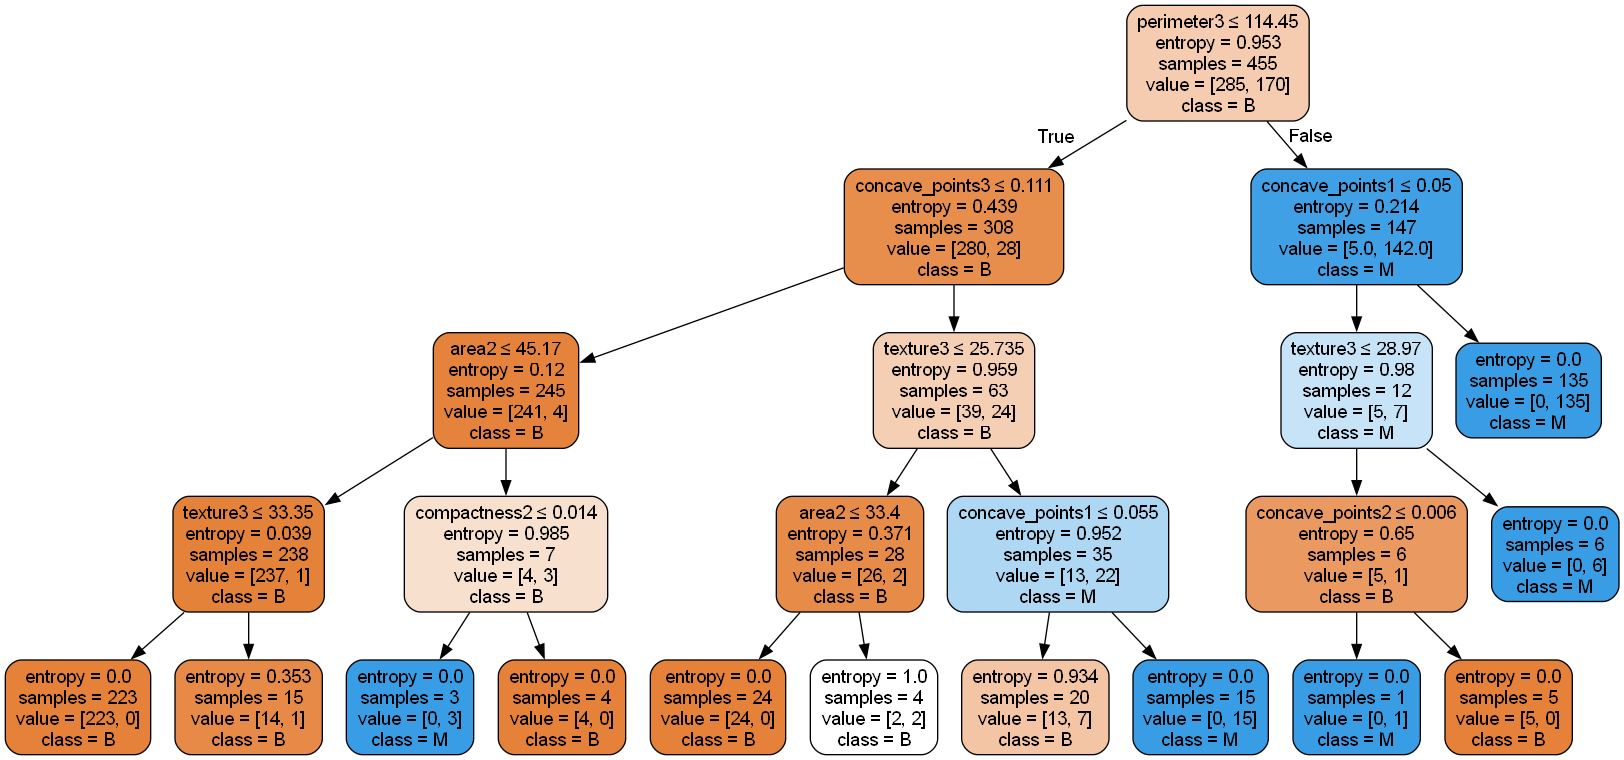

Decision Tree (max_depth=5):


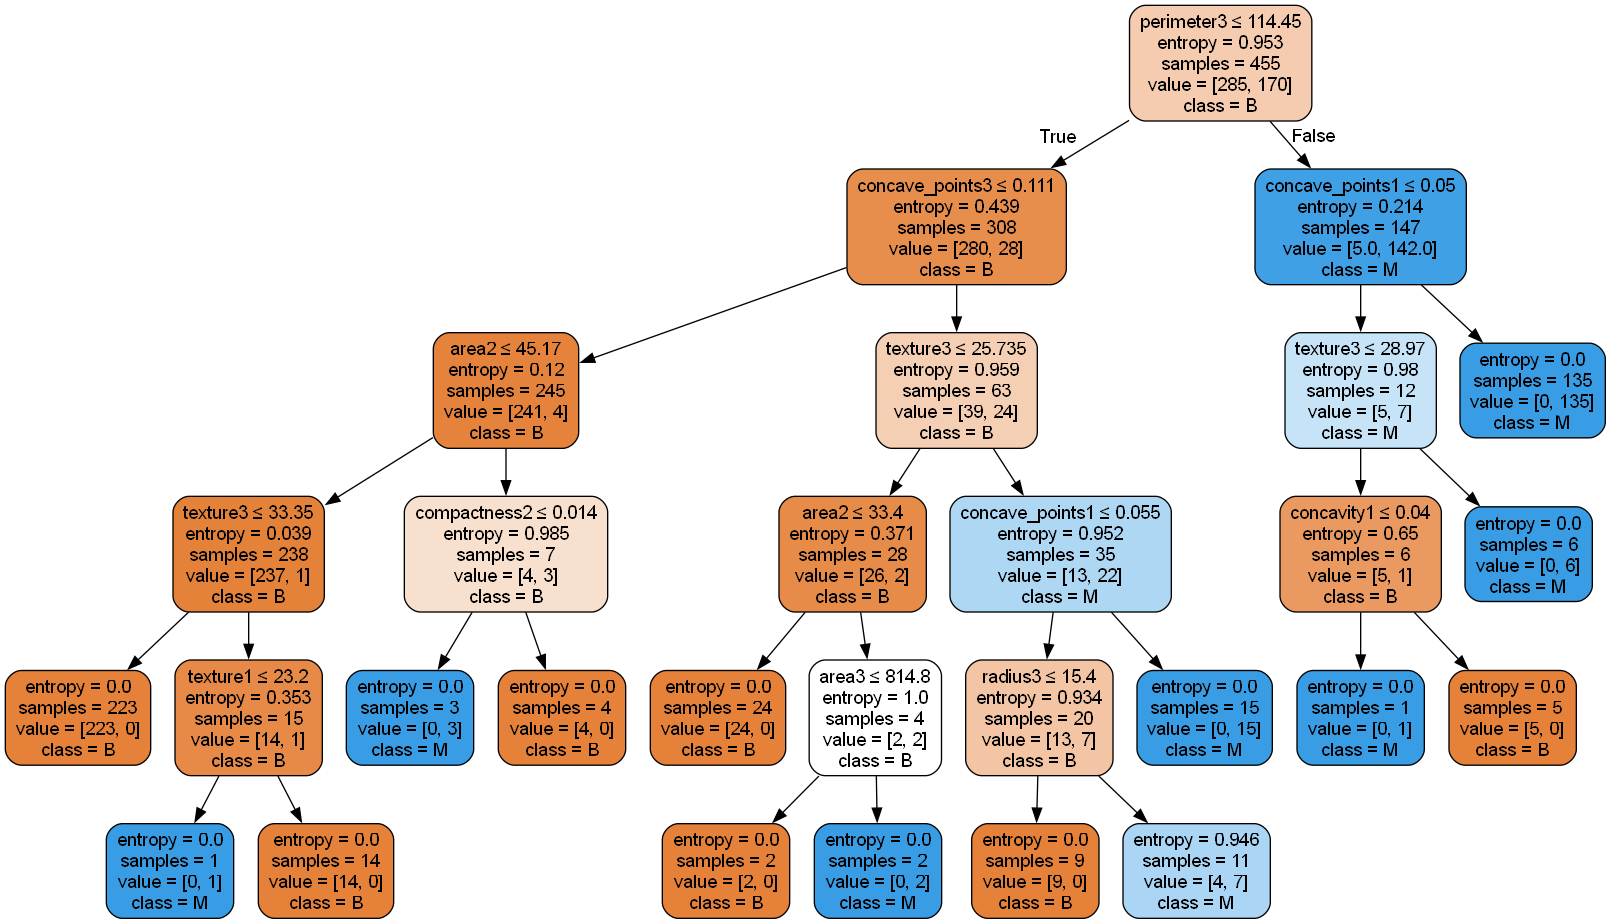

Decision Tree (max_depth=6):


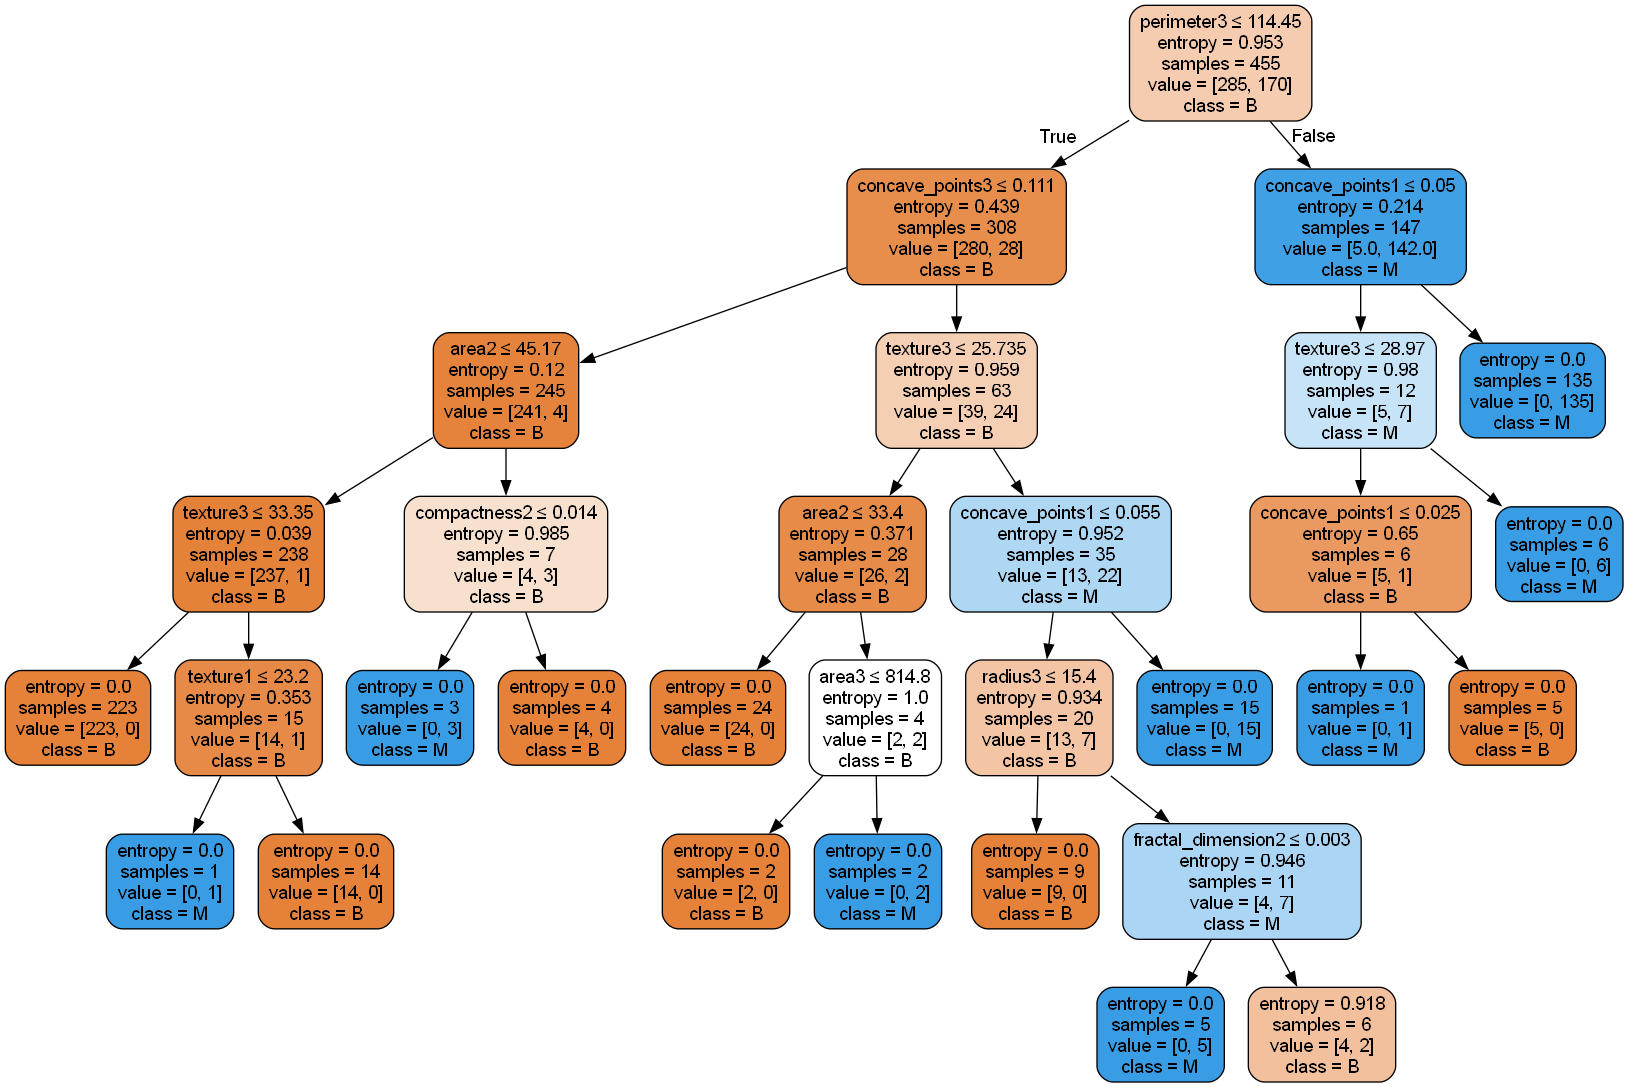

Decision Tree (max_depth=7):


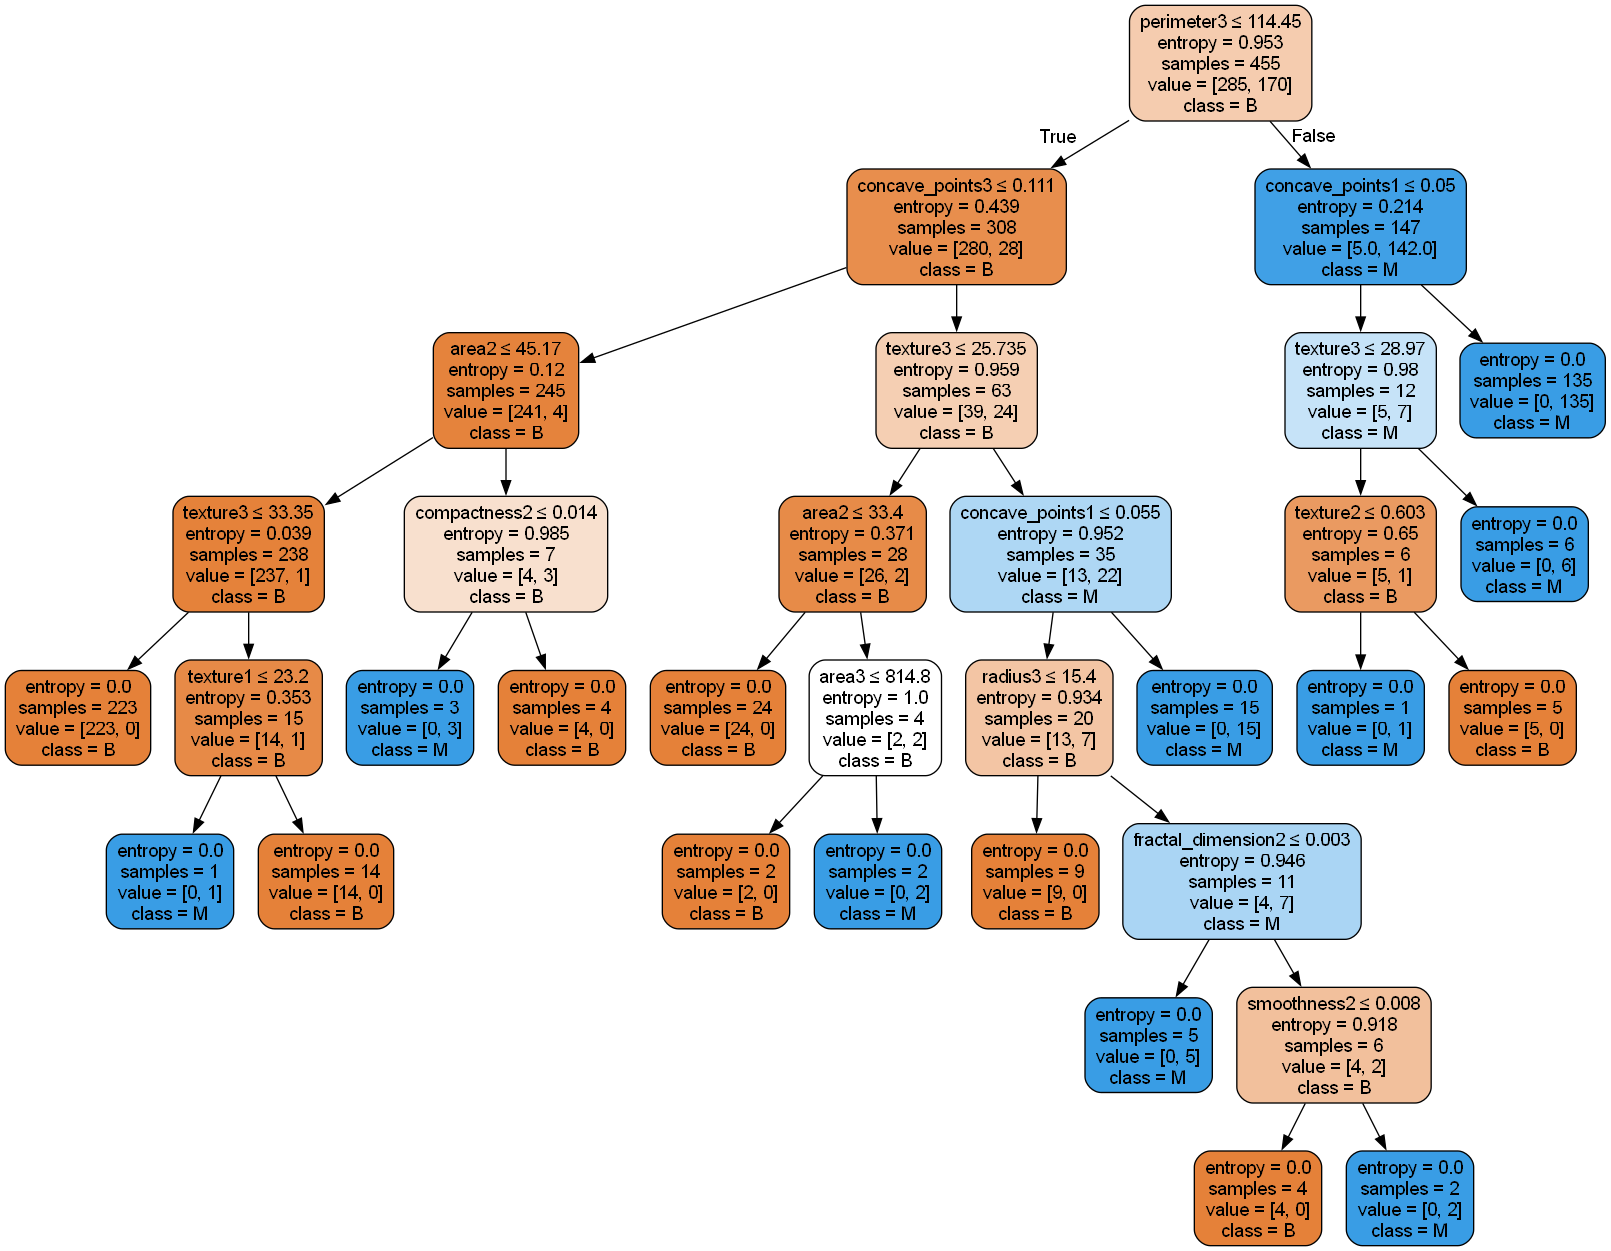

In [16]:
# Train and evaluate decision trees for different depths
dataset = None
for d in datasets:
    if d['train_size'] == 0.8:
        dataset = d
        break

# Ensure that we found the dataset with 80/20 split
if dataset is None:
    raise ValueError("No dataset found with 80/20 train-test split.")

for max_depth in depth_values:
    # Train the decision tree
    clf = DecisionTreeClassifier(criterion="entropy", random_state=42, max_depth=max_depth)
    clf.fit(dataset['feature_train'], dataset['label_train'])  # Train using current dataset

    # Predict and calculate accuracy
    predictions = clf.predict(dataset['feature_test'])
    accuracy = accuracy_score(dataset['label_test'], predictions)
    accuracy_results.append(accuracy)
    
    # Sort the class names to match their internal order in the tree
    sorted_class_names = sorted(dataset['label_train'].squeeze().unique())

    # Visualize the decision tree
    dot_data = export_graphviz(
        clf,
        out_file=None,
        feature_names=dataset['feature_train'].columns,
        class_names=sorted_class_names,
        filled=True,
        rounded=True,
        special_characters=True
    )
    graph = Source(dot_data)
    image_path = os.path.join(output_folder, f"DecisionTree_maxDepth_{max_depth}")
    graph.render(image_path, format='png', cleanup=True)

    # Display the tree in the notebook
    print(f"Decision Tree (max_depth={max_depth}):")
    display(Image(filename=image_path + ".png", width=1300))

In [17]:
# Create a table of accuracies
accuracy_table = pd.DataFrame({
    "max_depth": ["None" if d is None else d for d in depth_values],
    "Accuracy": accuracy_results
})
display(accuracy_table)

,max_depth,Accuracy
0,None,0.956140
1,2,0.885965
2,3,0.938596
3,4,0.929825
4,5,0.956140
5,6,0.929825
6,7,0.956140


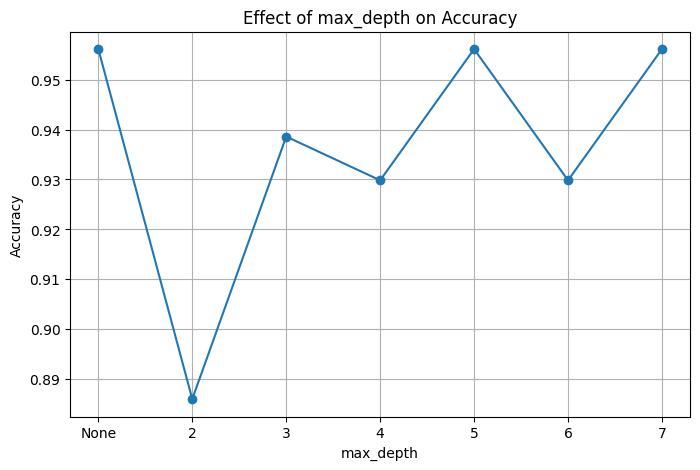

In [18]:
# Plot accuracy scores
plt.figure(figsize=(8, 5))
plt.plot(["None" if d is None else d for d in depth_values], accuracy_results, marker="o")
plt.title("Effect of max_depth on Accuracy")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()